# Topic classification with NN

Dataset:
    UKP ASPECT
    <br>Download Link: <href>https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/1998/UKP_ASPECT.zip?sequence=1&isAllowed=y</href>
<br><br>Steps:
1. Clean texts
2. Fit the base model - Logistic regression
3. Fit neural network model (with and without the dropout layers)

### Importing Required Libraries

In [1]:
import re
import nltk
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow_hub as hub
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf

## 1. Load Data and Convert to CSV

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
#Load data file
df = pd.read_csv("/content/drive/MyDrive/AM Thesis/topic-classification-NN-main/UKP_ASPECT.tsv", sep='\t')

df['sentence_1'] = df['sentence_1'] + ' . ' + df['sentence_2']
df = df.drop(['label'], axis = 1)
df = df.drop(['sentence_2'], axis = 1)
df = df.rename(columns = {'sentence_1': 'description', 'topic': 'type'})
df.head()

,type,description
0,3d printing,3D Printed Products Can Improve Health Outcome...
1,3d printing,This could greatly increase the quality of lif...
2,3d printing,Controlled Print Chamber: Controlled process e...
3,3d printing,Spark will make visualization of prints much e...
4,3d printing,Affordable 3D Printing for everyone With the U...


## 2. Preprocess text data

In [4]:
# Special characters and punctuation
punc_list = list("?:!.,;()")
df["description_1"] = df["description"].str.replace("\n", " ")
df["description_1"] = df["description_1"].str.replace('"', " ")
df["description_1"] = df["description_1"].str.replace("'s", " ")
for punc in punc_list:
    df["description_1"] = df["description_1"].str.replace(punc, " ")
    
#lowering cases
df["description_1"] = df["description_1"].str.lower()

<ipython-input-4-cba1bdf275c6>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["description_1"] = df["description_1"].str.replace(punc, " ")


In [7]:
#stemming and lemmatization
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

wordnet_lemmatizer = WordNetLemmatizer()
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['description_1']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [8]:
#stopwords
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['description_1'] = df['description_1'].str.replace(regex_stopword, '')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-8-cc3d58ac41a5>:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df['description_1'] = df['description_1'].str.replace(regex_stopword, '')


In [9]:
#remove numbers
pattern = r'[0-9]'
remove_number = []
for text in df["description_1"].tolist():
    remove_number.append(re.sub(pattern, '', text))
    
df["description_3"] = remove_number
df

,type,description,description_1,description_3
0,3d printing,3D Printed Products Can Improve Health Outcome...,3d printed products improve health outcomes ...,d printed products improve health outcomes r...
1,3d printing,This could greatly increase the quality of lif...,could greatly increase quality life curre...,could greatly increase quality life curre...
2,3d printing,Controlled Print Chamber: Controlled process e...,controlled print chamber controlled process e...,controlled print chamber controlled process e...
3,3d printing,Spark will make visualization of prints much e...,spark make visualization prints much easier ...,spark make visualization prints much easier ...
4,3d printing,Affordable 3D Printing for everyone With the U...,affordable 3d printing everyone mini 3d pr...,affordable d printing everyone mini d prin...
...,...,...,...,...
3590,Wind power,"Wind power reduces pollution, is sustainable a...",wind power reduces pollution sustainable l...,wind power reduces pollution sustainable l...
3591,Wind power,The wind turbine 100 may be installed on any t...,wind turbine 100 may installed terrain pro...,wind turbine may installed terrain provid...
3592,Wind power,MSUs power flow controller can be installed an...,msus power flow controller installed anywher...,msus power flow controller installed anywher...
3593,Wind power,Our mission is to allow people to meet through...,mission allow people meet 3d avatars e...,mission allow people meet d avatars ea...


In [10]:
list_columns = ["description_3", "type"]
df2 = df[list_columns]

df2 = df2.rename(columns={'description_3': 'description'})

In [11]:
df2

,description,type
0,d printed products improve health outcomes r...,3d printing
1,could greatly increase quality life curre...,3d printing
2,controlled print chamber controlled process e...,3d printing
3,spark make visualization prints much easier ...,3d printing
4,affordable d printing everyone mini d prin...,3d printing
...,...,...
3590,wind power reduces pollution sustainable l...,Wind power
3591,wind turbine may installed terrain provid...,Wind power
3592,msus power flow controller installed anywher...,Wind power
3593,mission allow people meet d avatars ea...,Wind power


#### Label encoding

In [12]:
category_codes = {'3d printing': 0}
category = df2['type'].unique()
for i in range(1, len(category)):
    category_codes.update({category[i]: i})

# Category mapping
df2['type_code'] = df2['type']
df2 = df2.replace({'type_code':category_codes})

df2.tail()

,description,type,type_code
3590,wind power reduces pollution sustainable l...,Wind power,27
3591,wind turbine may installed terrain provid...,Wind power,27
3592,msus power flow controller installed anywher...,Wind power,27
3593,mission allow people meet d avatars ea...,Wind power,27
3594,every wind turbine slows wind thus reducing...,Wind power,27


#### Split train-test sets

In [13]:
# imbalanced -- have to assign class weights
df2['type'].value_counts()

# split train - test
X_train, X_test, y_train, y_test = train_test_split(df2['description'], 
                                                    df2['type'], 
                                                    test_size=0.15, 
                                                    random_state=8)

In [14]:
df2

,description,type,type_code
0,d printed products improve health outcomes r...,3d printing,0
1,could greatly increase quality life curre...,3d printing,0
2,controlled print chamber controlled process e...,3d printing,0
3,spark make visualization prints much easier ...,3d printing,0
4,affordable d printing everyone mini d prin...,3d printing,0
...,...,...,...
3590,wind power reduces pollution sustainable l...,Wind power,27
3591,wind turbine may installed terrain provid...,Wind power,27
3592,msus power flow controller installed anywher...,Wind power,27
3593,mission allow people meet d avatars ea...,Wind power,27


## 3. The base model - Logistic Regression

#### Step 0: Transform the train, test data

To implement Logistic Regression, we first have to tokenize the text of train, test sets

In [15]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(3055, 300)
(540, 300)


#### Step 1: Random Grid Search

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Grid search for the best parameter, a summary

# lr_0 = LogisticRegression(random_state = 8)
# print('Parameters currently in use:\n')
# print(lr_0.get_params())

# '''''''''''''''''''''''''''''''''DEFINING THE PARAMETERS'''''''''''''
# C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]
# multi_class = ['multinomial']
# solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
# class_weight = ['balanced', None]
# penalty = ['l2']

# random_grid = {'C': C,
#                'multi_class': multi_class,
#                'solver': solver,
#                'class_weight': class_weight,
#                'penalty': penalty}

# print(random_grid)

# '''''''''''''''''''''''''''''''''''''FIT THE MODEL'''''''''''''
# lrc = LogisticRegression(random_state=8)
# random_search = RandomizedSearchCV(estimator=lrc,
#                                    param_distributions=random_grid,
#                                    n_iter=50,
#                                    scoring='accuracy',
#                                    cv=3, 
#                                    verbose=1, 
#                                    random_state=8)
# random_search.fit(features_train, labels_train)

# '''''''''''''''''''''''''''''''''''''EXTRACT THE BEST COMBINATION OF PARAMETERS'''''''''''''
# print("The best hyperparameters from Random Search are:")
# print(random_search.best_params_)
# print("")
# print("The mean accuracy of a model with these hyperparameters is:")
# print(random_search.best_score_)

#### Step 2: Tighter parameter search (with cross-validation) in the optimal range from the result above

In [17]:
# '''''''''''''''''''''''''''''''''DEFINING THE PARAMETERS'''''''''''''
# Create the parameter grid based on the results of random search 
# C = [float(x) for x in np.linspace(start = 0.5, stop = 0.9, num = 10)]
# multi_class = ['multinomial']
# solver = ['sag']
# class_weight = [None]
# penalty = ['l2']

# param_grid = {'C': C,
#                'multi_class': multi_class,
#                'solver': solver,
#                'class_weight': class_weight,
#                'penalty': penalty}

# '''''''''''''''''''''''''''''''''''''FIT THE MODEL'''''''''''''
# lrc = LogisticRegression(random_state=8)
# cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)
# grid_search = GridSearchCV(estimator=lrc, 
#                            param_grid=param_grid,
#                            scoring='accuracy',
#                            cv=cv_sets,
#                            verbose=1)

# # Fit the grid search to the data
# grid_search.fit(features_train, labels_train)

# '''''''''''''''''''''''''''''''''''''EXTRACT THE BEST COMBINATION OF PARAMETERS'''''''''''''
# print("The best hyperparameters from Grid Search are:")
# print(grid_search.best_params_)
# print("")
# print("The mean accuracy of a model with these hyperparameters is:")
# print(grid_search.best_score_)

#best_lrc = grid_search.best_estimator_

The best hyperparameters from Grid Search are:
{'C': 0.7222222222222222, 'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

In [18]:
best_lrc = LogisticRegression(C=0.7222222222222222, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)
best_lrc.fit(features_train, labels_train)

LogisticRegression(C=0.7222222222222222, multi_class='multinomial',
                   random_state=8, solver='sag')

In [19]:
lrc_pred = best_lrc.predict(features_test)

# Training accuracy

print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

# Test accuracy

print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The training accuracy is: 
0.8959083469721768
The test accuracy is: 
0.8981481481481481


In [20]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
                     precision    recall  f1-score   support

        3d printing       0.88      0.88      0.88        16
           Big data       0.93      1.00      0.96        25
      Cloud storing       0.83      0.88      0.86        17
     Cryptocurrency       0.77      0.89      0.83        19
             Drones       0.89      0.94      0.92        18
      Electric cars       0.85      0.85      0.85        20
  Electronic voting       1.00      0.91      0.95        22
           Fracking       0.93      0.82      0.87        17
       Gene editing       0.85      0.85      0.85        13
  Genetic diagnosis       0.91      0.87      0.89        23
     Geoengineering       1.00      0.80      0.89        20
                Gmo       0.85      0.77      0.81        22
 Hydroelectric dams       0.60      0.86      0.71         7
Hydrogen fuel cells       0.92      0.89      0.91        27
 Internet of things       0.83      0.83      0.83        18
 

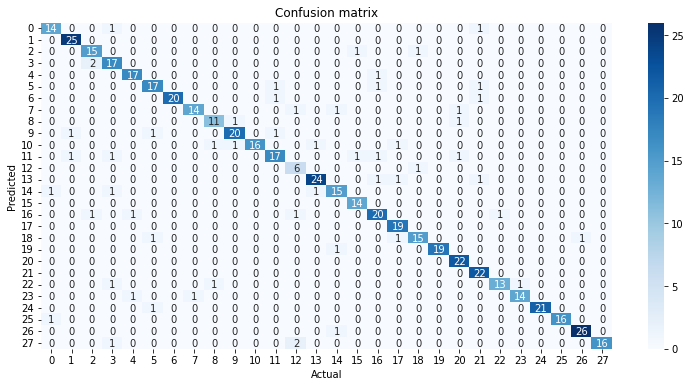

In [21]:
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

## 4. Fit the neural network model

In [22]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight(class_weight= 'balanced', 
                                                       classes = np.unique(df2['type']), 
                                                       y = df2['type']))

class_weights

[1.0109673790776152,
 0.9876373626373627,
 1.0030691964285714,
 1.0030691964285714,
 0.9876373626373627,
 0.9876373626373627,
 0.9876373626373627,
 1.0030691964285714,
 1.0789315726290516,
 0.9876373626373627,
 0.9952934662236987,
 1.0030691964285714,
 0.9952934662236987,
 0.9876373626373627,
 0.9876373626373627,
 0.9952934662236987,
 0.9876373626373627,
 0.9952934662236987,
 0.9876373626373627,
 0.9876373626373627,
 0.9876373626373627,
 0.9952934662236987,
 1.035426267281106,
 1.035426267281106,
 1.0109673790776152,
 0.9876373626373627,
 0.9876373626373627,
 1.0109673790776152]

In [23]:
weights = {}
for index, weight in enumerate(class_weights) :
    weights[index] = weight
    
weights

{0: 1.0109673790776152,
 1: 0.9876373626373627,
 2: 1.0030691964285714,
 3: 1.0030691964285714,
 4: 0.9876373626373627,
 5: 0.9876373626373627,
 6: 0.9876373626373627,
 7: 1.0030691964285714,
 8: 1.0789315726290516,
 9: 0.9876373626373627,
 10: 0.9952934662236987,
 11: 1.0030691964285714,
 12: 0.9952934662236987,
 13: 0.9876373626373627,
 14: 0.9876373626373627,
 15: 0.9952934662236987,
 16: 0.9876373626373627,
 17: 0.9952934662236987,
 18: 0.9876373626373627,
 19: 0.9876373626373627,
 20: 0.9876373626373627,
 21: 0.9952934662236987,
 22: 1.035426267281106,
 23: 1.035426267281106,
 24: 1.0109673790776152,
 25: 0.9876373626373627,
 26: 0.9876373626373627,
 27: 1.0109673790776152}

In [24]:
# create the train and test sets suitable for NN model
dataset_train = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [25]:
for text, target in dataset_train.take(5):
    print('Desc: {}, label: {}'.format(text, target))

Desc: b'biotechnology  medical device  pharmaceutical companies  academic centers statewide  incorporating stem cells   way   research  development     combination  stem cells  targeted genome editing technology provides  powerful tool  model human diseases  develop potential cell replacement therapy ', label: b'Net neutrality'
Desc: b' moratorium  offshore drilling   held   risks far outweigh  potential costs    declining demand  oil    adverse effect   offshore drilling industry  lower oil prices reduce day rates earned  offshore drilling rigs ', label: b'Offshore drilling'
Desc: b"spills  leaks  one way fracking could lead  water contamination    relatively easy  manage      fracking contaminates drinking water  fracking ' make  water flammable   must  least contaminate   dangerous chemicals  right ", label: b'Fracking'
Desc: b'ways  recycle  recognizes  recycle  many products  help save  planet   current events recently noted    important     food service staff  implemented  zero w

In [26]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(category_codes.keys())),
        values = tf.constant(list(category_codes.values()))
    ),
    default_value=tf.constant(-1),
    name="target_encoding"
)

@tf.function
def target(x):
    return table.lookup(x)

In [27]:
def fetch(text, labels):
    '''
    Purpose: one hot encoding the labels of the dataset
    '''
    return text, tf.one_hot(target(labels), 19)

train_data_fetch = dataset_train.map(fetch)
test_data_fetch = dataset_test.map(fetch)

# get a batch of data
train_data, train_labels = next(iter(dataset_train.map(fetch).batch(1000)))

#### Start creating a model

I'm going to fit the model without the dropout layers first, then compare it with the dropout layers method. For the model, I'm using an open-source embedding layer that handles the tokenization task for us.

In [28]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, output_shape=[128],input_shape=[], dtype=tf.string,
                          trainable=True)
#demonstrate how this layer tokenize the text
hub_layer(train_data[:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 1.86898604e-01, -6.78474009e-02,  1.55039474e-01,
        -5.03670931e-01, -2.38705322e-01,  1.26698345e-01,
         3.52263570e-01, -2.58769870e-01, -3.19436491e-01,
         3.72054428e-01, -2.96802428e-02, -1.05767637e-01,
         7.25458786e-02,  1.33288890e-01, -3.02768141e-01,
        -5.15785277e-01, -2.13364974e-01, -1.84427917e-01,
         1.34845361e-01,  1.04087785e-01,  2.47993872e-01,
        -2.05968782e-01, -5.86958975e-02, -1.04299203e-01,
         3.03703189e-01,  5.80461212e-02,  2.26616099e-01,
         2.38112971e-01, -4.25065607e-02,  3.39460224e-02,
         1.22054622e-01,  1.37946442e-01,  9.51155797e-02,
         2.21702158e-01, -2.91936956e-02,  1.41604140e-01,
         5.07518239e-02,  4.90488373e-02,  3.87313455e-01,
        -3.39394845e-02, -1.13828024e-02, -5.49491383e-02,
         1.68742053e-02,  1.89467072e-01, -1.44293293e-01,
        -3.08408309e-02,  2.45993823e-01, -5.52684106e-02,
      

In [29]:
#build the basic model without dropout
model_wo_dropout = tf.keras.Sequential()
model_wo_dropout.add(hub_layer)
for units in [128, 128, 64, 32]:
    model_wo_dropout.add(tf.keras.layers.Dense(units, activation='relu'))
model_wo_dropout.add(tf.keras.layers.Dense(19, activation='softmax'))

model_wo_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 19)                627       
                                                                 
Total params: 124,686,675
Trainable params: 124,686,675


In [30]:
#compile the model
model_wo_dropout.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
train_data_fetch = train_data_fetch.shuffle(70000).batch(512)
test_data_fetch = test_data_fetch.batch(512)

In [32]:
#fit the model
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True, verbose=1)
text_classifier_wo_dropout = model_wo_dropout.fit(train_data_fetch, epochs=25, validation_data = test_data_fetch,
                   verbose=1, class_weight=weights, callbacks =[earlystopping])

Epoch 1/25


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


6/6 [==============================] - 13s 2s/step - loss: 1.9851 - accuracy: 0.0907 - val_loss: 1.8969 - val_accuracy: 0.1352
Epoch 2/25
6/6 [==============================] - 8s 1s/step - loss: 1.9032 - accuracy: 0.1502 - val_loss: 1.7858 - val_accuracy: 0.1704
Epoch 3/25
6/6 [==============================] - 8s 1s/step - loss: 1.7589 - accuracy: 0.1928 - val_loss: 1.6058 - val_accuracy: 0.2722
Epoch 4/25
6/6 [==============================] - 8s 1s/step - loss: 1.5323 - accuracy: 0.3038 - val_loss: 1.3497 - val_accuracy: 0.3833
Epoch 5/25
6/6 [==============================] - 7s 1s/step - loss: 1.2302 - accuracy: 0.4088 - val_loss: 1.0727 - val_accuracy: 0.4259
Epoch 6/25
6/6 [==============================] - 7s 1s/step - loss: 0.9095 - accuracy: 0.4707 - val_loss: 0.7994 - val_accuracy: 0.4926
Epoch 7/25
6/6 [==============================] - 7s 1s/step - loss: 0.6312 - accuracy: 0.5558 - val_loss: 0.6250 - val_accuracy: 0.5500
Epoch 8/25
6/6 [==============================] - 9

In [33]:
#evaluate the model
test_length = len(list(dataset_test))
results = model_wo_dropout.evaluate(dataset_test.map(fetch).batch(test_length), verbose=2)
print(results)

1/1 - 0s - loss: 0.4677 - accuracy: 0.5796 - 118ms/epoch - 118ms/step
[0.46767303347587585, 0.5796296000480652]


In [34]:
#training errors
y_train_pred = model_wo_dropout.predict(train_data)

print(classification_report(train_labels.numpy().argmax(axis=1), y_train_pred.argmax(axis=1)))

32/32 [==============================] - 4s 127ms/step
              precision    recall  f1-score   support

           0       0.88      0.13      0.22       343
           1       0.66      0.94      0.77        31
           2       0.87      0.91      0.89        43
           3       0.97      0.94      0.96        36
           4       1.00      0.68      0.81        44
           5       1.00      0.86      0.92        42
           6       0.89      0.91      0.90        34
           7       1.00      0.97      0.99        40
           8       0.45      1.00      0.62        32
           9       0.12      1.00      0.21        22
          10       0.97      0.95      0.96        39
          11       0.92      0.94      0.93        35
          12       0.32      0.98      0.48        46
          13       1.00      0.86      0.93        36
          14       0.69      1.00      0.81        37
          15       1.00      0.85      0.92        34
          16       1.00   

In [35]:
# test errors
test_data, test_labels = next(iter(dataset_test.map(fetch).batch(test_length)))
y_pred = model_wo_dropout.predict(test_data)

print(classification_report(test_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1)))

17/17 [==============================] - 2s 118ms/step
              precision    recall  f1-score   support

           0       0.79      0.10      0.17       197
           1       0.83      1.00      0.91        25
           2       0.73      0.94      0.82        17
           3       0.86      0.95      0.90        19
           4       1.00      0.61      0.76        18
           5       1.00      0.85      0.92        20
           6       0.87      0.91      0.89        22
           7       1.00      0.82      0.90        17
           8       0.28      0.85      0.42        13
           9       0.17      0.91      0.28        23
          10       0.89      0.80      0.84        20
          11       0.94      0.77      0.85        22
          12       0.12      0.86      0.20         7
          13       1.00      0.81      0.90        27
          14       0.61      0.94      0.74        18
          15       0.93      1.00      0.97        14
          16       0.95   

#### Model with Dropout layers for confirmation of overfitting

In [36]:
# re-create train, test data for fitting the model
train_data_fetch_dropout = dataset_train.map(fetch)
test_data_fetch_dropout = dataset_test.map(fetch)

In [37]:
# build a similar model but with the dropout layers
model = tf.keras.Sequential()
model.add(hub_layer)
for units in [128, 128, 64]:
    model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(19, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [38]:
#compile the model
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
train_data_fetch_dropout = train_data_fetch_dropout.shuffle(10000).batch(1500)
test_data_fetch_dropout = test_data_fetch_dropout.batch(512)

In [40]:
#fit the model
text_classifier = model.fit(train_data_fetch_dropout, epochs=100, validation_data = test_data_fetch_dropout,
                   verbose=1, class_weight=weights, callbacks =[earlystopping])

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 5s 2s/step - loss: 2.0164 - accuracy: 0.0661 - val_loss: 1.9405 - val_accuracy: 0.2093
Epoch 2/100
3/3 [==============================] - 4s 1s/step - loss: 1.9874 - accuracy: 0.1191 - val_loss: 1.9156 - val_accuracy: 0.3093
Epoch 3/100
3/3 [==============================] - 4s 1s/step - loss: 1.9650 - accuracy: 0.1502 - val_loss: 1.8894 - val_accuracy: 0.3426
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 1.9426 - accuracy: 0.1745 - val_loss: 1.8592 - val_accuracy: 0.4389
Epoch 5/100
3/3 [==============================] - 4s 1s/step - loss: 1.9163 - accuracy: 0.2075 - val_loss: 1.8247 - val_accuracy: 0.4574
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 1.8838 - accuracy: 0.2458 - val_loss: 1.7831 - val_accuracy: 0.4852
Epoch 7/100
3/3 [==============================] - 4s 1s/step - loss: 1.8398 - accuracy: 0.2576 - val_loss: 1.7288 - val_accuracy: 0.5111
Epoch 8/100
3/3 [=============================

In [41]:
test_length = len(list(dataset_test))
results = model.evaluate(dataset_test.map(fetch).batch(test_length), verbose=2)
print(results)

1/1 - 0s - loss: 0.7242 - accuracy: 0.6278 - 220ms/epoch - 220ms/step
[0.7241824865341187, 0.6277777552604675]


We look closer at the confusing matrices

In [42]:
# training errors
y_train_pred_dropout = model.predict(train_data)

print(classification_report(train_labels.numpy().argmax(axis=1), y_train_pred_dropout.argmax(axis=1)))

32/32 [==============================] - 4s 136ms/step
              precision    recall  f1-score   support

           0       0.95      0.48      0.64       343
           1       0.97      0.90      0.93        31
           2       0.97      0.88      0.93        43
           3       0.75      0.08      0.15        36
           4       0.63      0.93      0.75        44
           5       0.44      0.90      0.59        42
           6       1.00      0.88      0.94        34
           7       1.00      0.95      0.97        40
           8       0.13      0.97      0.23        32
           9       0.90      0.86      0.88        22
          10       1.00      0.87      0.93        39
          11       1.00      0.74      0.85        35
          12       0.90      0.96      0.93        46
          13       1.00      0.22      0.36        36
          14       0.94      0.86      0.90        37
          15       0.85      0.82      0.84        34
          16       1.00   

In [43]:
# testing errors
test_data, test_labels = next(iter(dataset_test.map(fetch).batch(test_length)))
y_pred = model.predict(test_data)

print(classification_report(test_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1)))

17/17 [==============================] - 2s 121ms/step
              precision    recall  f1-score   support

           0       0.98      0.42      0.59       197
           1       0.96      1.00      0.98        25
           2       1.00      0.82      0.90        17
           3       1.00      0.05      0.10        19
           4       0.47      1.00      0.64        18
           5       0.31      0.85      0.46        20
           6       1.00      0.91      0.95        22
           7       1.00      0.82      0.90        17
           8       0.08      0.85      0.15        13
           9       0.87      0.87      0.87        23
          10       1.00      0.80      0.89        20
          11       1.00      0.45      0.62        22
          12       0.43      0.86      0.57         7
          13       1.00      0.19      0.31        27
          14       1.00      0.83      0.91        18
          15       0.88      1.00      0.93        14
          16       1.00   

In [45]:
! pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 22.6 MB/s eta 0:00:00


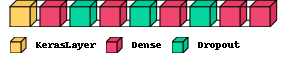

In [50]:
import visualkeras
visualkeras.layered_view(model, legend=True)